In [1]:
%load_ext autoreload
%autoreload 2

# DBpedia experiments

In [2]:
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.datareader import DBpediaReader

%matplotlib inline

Set seed for reproducibility

In [3]:
np.random.seed(117)

## Data description

In [4]:
text_reader = DBpediaReader()
data, X, mmcorp, corpdict = text_reader.get_sample_data()

In [5]:
data.head()

,Unnamed: 0,text,l1,l2,l3,wiki_name,word_count
0,122474,Campbell Hospital is a National Health Service...,Place,Building,Hospital,"Campbell_Hospital,_Portsoy",49
1,99246,The Favàritx Lighthouse is an active lighthous...,Place,Tower,Lighthouse,Favàritx_Lighthouse,13
2,135736,Château de la Petite Filolie is a château in D...,Place,Building,Castle,Château_de_la_Petite_Filolie,12
3,100462,Skyrush is an Intamin prototype Wing Coaster w...,Place,AmusementParkAttraction,RollerCoaster,Skyrush,209
4,105687,M-82 is a state trunkline in the Lower Peninsu...,Place,RouteOfTransportation,Road,M-82_(Michigan_highway),102


### Check data by label counts
Level-1 labels

In [6]:
print(f"Number of Level-1 labels: {len(data['l1'].unique())}")
data.value_counts(['l1']).to_frame('counts')

Number of Level-1 labels: 2


,counts
l1,
Agent,667
Place,333


<AxesSubplot:>

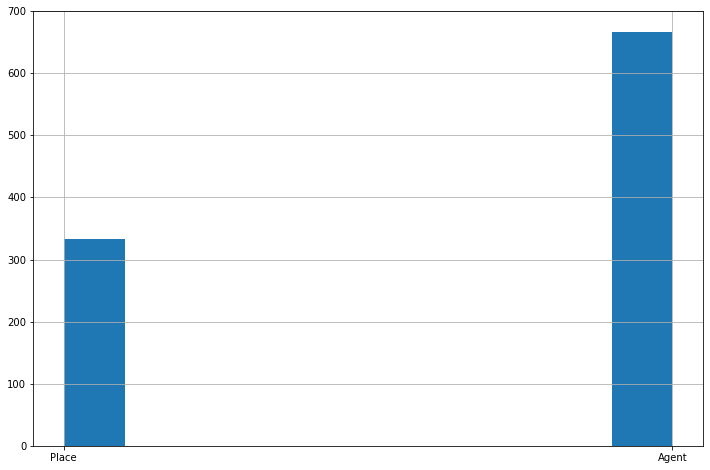

In [7]:
plt.figure(figsize=(12,8))
data['l1'].hist()

Level-2 labels

In [8]:
print(f"Number of Level-2 labels: {len(data['l2'].unique())}")
data.value_counts(['l1', 'l2']).to_frame('counts').sort_index()

Number of Level-2 labels: 45


counts
l1    l2                                  
Agent Actor                              4
      Artist                            26
      Athlete                          179
      Boxer                              2
      BritishRoyalty                     2
      Broadcaster                       29
      Cleric                            28
      Coach                              7
      ComicsCharacter                    1
      Company                           44
      EducationalInstitution            26
      FictionalCharacter                 8
      GridironFootballPlayer            13
      Group                              7
      MotorcycleRider                    3
      Organisation                      39
      OrganisationMember                 2
      Person                           102
      Politician                        46
      Presenter                          1
      RacingDriver                       5
      Scientist                          2
      SportsLeague                       9
      SportsManager                     13
      SportsTeam                        32
      VolleyballPlayer                   3
      WinterSportPlayer                 27
      Wrestler                           1
      Writer                             6
Place AmusementParkAttraction            4
      BodyOfWater                       11
      Building                          69
      CelestialBody                     19
      ClericalAdministrativeRegion      14
      Infrastructure                    22
      NaturalPlace                      47
      RaceTrack                          2
      RouteOfTransportation             43
      Satellite                         13
      Settlement                        24
      SportFacility                     18
      Station                           15
      Stream                            18
      Tower                             13
      Venue                              1

<AxesSubplot:xlabel='l1,l2'>

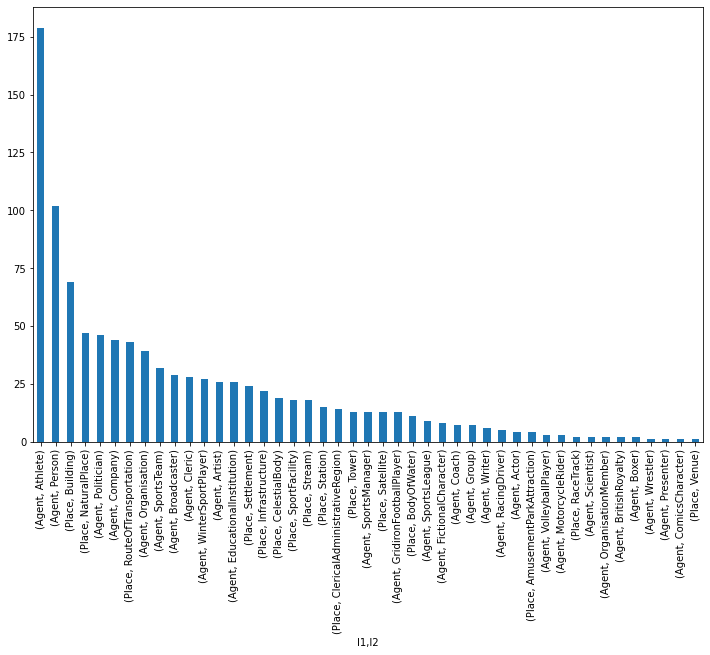

In [9]:
plt.figure(figsize=(12,8))
data[['l1', 'l2']].value_counts().plot(kind="bar")

Level-3 labels

In [10]:
print(f"Number of Level-3 labels: {len(data['l3'].unique())}")
data.value_counts(['l1', 'l2', 'l3']).to_frame('counts').sort_index()

Number of Level-3 labels: 149


counts
l1    l2      l3                     
Agent Actor   AdultActor            4
      Artist  Comedian              3
              ComicsCreator        12
              FashionDesigner       3
              Painter               7
...                               ...
Place Station RailwayStation       15
      Stream  Canal                 1
              River                17
      Tower   Lighthouse           13
      Venue   Theatre               1

[149 rows x 1 columns]

Text(0, 0.5, 'Number of labels')

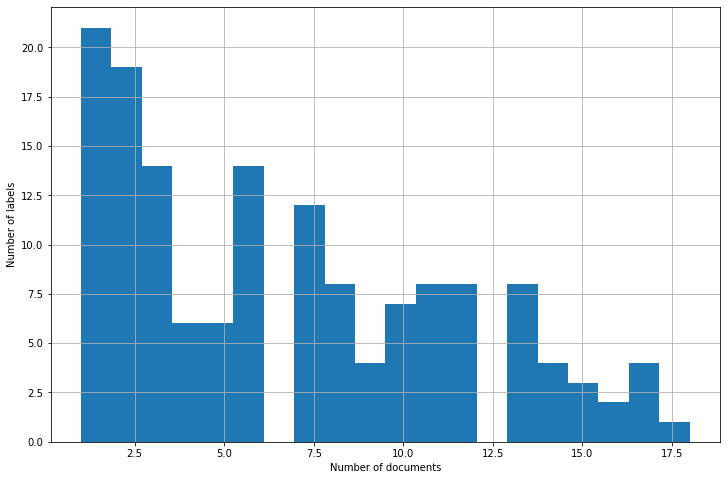

In [11]:
plt.figure(figsize=(12,8))
data.value_counts(['l1', 'l2', 'l3']).to_frame('counts')['counts'].hist(bins=20)
plt.xlabel('Number of documents')
plt.ylabel('Number of labels')

### Helper functions for getting top keywords

In [12]:
def get_topics(X, labels, cdict, topk=10):
    m, _   = X.shape
    ulabs  = np.unique(labels)
    topics = []
    
    for idx, lab in enumerate(ulabs):
        x_topic = np.mean(X[:, labels == lab], axis=1)
        x_topic = np.squeeze(np.asarray(x_topic))
        topk_ix = heapq.nlargest(topk, range(m), x_topic.take)
        w_top   = [cdict[ix] for ix in topk_ix]
        topics.append(w_top)
        
    return topics

In [13]:
def get_labels(datadf, hlabs):
    numdocs = len(datadf)
    nhiers  = len(hlabs)
    
    labels  = np.zeros((numdocs, nhiers))
    lnames  = []
    
    for idx in range(nhiers):
        ulabs = datadf[hlabs[idx]].unique()
        lnames.append(ulabs.tolist())
        
        for (lidx, lab) in enumerate(ulabs):
            labels[datadf[hlabs[idx]] == lab, idx] = lidx
            
    return labels, lnames

In [14]:
hierlabels = ['l1', 'l2', 'l3']
labels, lnames = get_labels(data, hierlabels)

In [15]:
topics = []
for idx in range(labels.shape[1]):
    ltopics = get_topics(X, labels[:,idx], corpdict)
    topics.append(ltopics)

### Print some random topics

In [16]:
for lvl in range(labels.shape[1]):
    nlabs = len(lnames[lvl])
    print(f'Number of labels in Level-{lvl}: {nlabs}')
    nchoices = np.minimum(5, nlabs)
    labchoices = np.random.choice(range(nlabs), nchoices, replace=False)
    
    print(f"{nchoices} topics from Level-{lvl}")
    for lab in labchoices:
        print(f"Top keywords for topic: {lnames[lvl][lab]} ({sum(labels[:,lvl] == lab)} documents)")
        print(topics[lvl][lab])
        
    print("\n")

Number of labels in Level-0: 2
2 topics from Level-0
Top keywords for topic: Agent (667 documents)
['play', 'born', 'footbal', 'team', 'player', 'leagu', 'club', 'univers', 'world', 'school']
Top keywords for topic: Place (333 documents)
['river', 'mountain', 'line', 'station', 'bridg', 'church', 'locat', 'lake', 'dam', 'km']


Number of labels in Level-1: 45
5 topics from Level-1
Top keywords for topic: ComicsCharacter (1 documents)
['charact', 'anim', 'seri', 'soul', 'adapt', 'review', 'poll', 'protagonist', 'voic', 'japanes']
Top keywords for topic: Wrestler (1 documents)
['mongolia', 'wrestler', 'enter', 'involv', 'japan', 'highest', 'rank', 'sport', 'top', 'forc']
Top keywords for topic: Organisation (39 documents)
['union', 'parti', 'congress', 'council', 'navi', 'trade', 'air', 'elect', 'railway', 'unit']
Top keywords for topic: Company (44 documents)
['label', 'record', 'bank', 'publish', 'oper', 'airlin', 'compani', 'music', 'breweri', 'firm']
Top keywords for topic: SportsLea